## IMPORTING LIBRARIES and Defining our directories where files are stored

In [3]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
pip install keras

In [5]:
import tensorflow as tf
import keras

In [7]:
train_dir = 'C:/Users/91053/Downloads/comp6321/comp6321_project/train/'
test_dir = 'C:/Users/91053/Downloads/comp6321/comp6321_project/test/'

In [8]:
row=48
col=48
classes = 7

### COUNT EXPRESSION FUNCTION TO STORE NO. OF IMAGES IN A EXPRESSION FOLDER

In [9]:
def count_expression(path,set_):
    dict_={}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression]=len(os.listdir(dir_))

    df = pd.DataFrame(dict_,index=[set_])
    return df

In [10]:
train_count=count_expression(train_dir,'train_count')
print(train_count)

             angry  disgust  fear  happy  neutral   sad  surprise
train_count   3995      436  4097   7215     4965  4830      3171


In [11]:
test_count=count_expression(test_dir,'test')
print(test_count)

      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


Text(0.5, 1.0, 'Plot of number of images in train dataset')

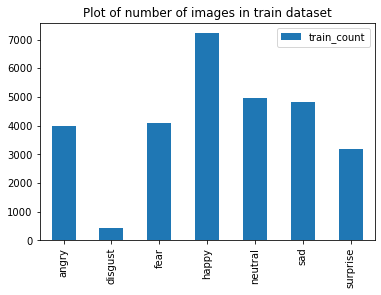

In [12]:
train_count.transpose().plot(kind = "bar")
plt.title('Plot of number of images in train dataset')

Text(0.5, 1.0, 'Plot of number of images in test dataset')

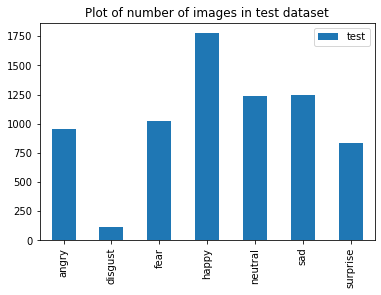

In [13]:
test_count.transpose().plot(kind = "bar")
plt.title('Plot of number of images in test dataset')

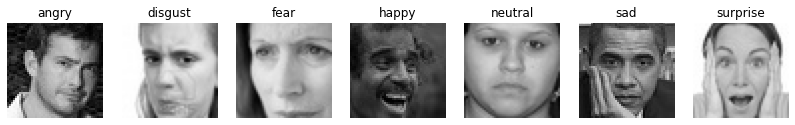

In [14]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = keras.preprocessing.image.load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

## Preprocessing

In [15]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D,Dense, MaxPooling2D,Flatten,Dropout,Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger,TensorBoard,EarlyStopping,ReduceLROnPlateau
import datetime
from tensorflow.keras.utils import plot_model

In [16]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                    zoom_range=0.3, 
                                    horizontal_flip=True)
# rotation_range=40,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         fill_mode='nearest'

train_set=train_datagen.flow_from_directory(train_dir,
                                            batch_size=64,
                                            target_size=(48,48),
                                            shuffle=True,
                                            color_mode="grayscale",class_mode='categorical')



test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                            batch_size=64,
                                            target_size=(48,48),
                                            shuffle=True,
                                            color_mode="grayscale",class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [17]:
train_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

## MODEL-BUILDING

In [18]:
#initalising the CNN model

def get_model(input_size, classes=7):
     #BUILDING the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    #COMPLILING the CNN
    model.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [19]:
our_model = get_model((row,col,1),classes)
our_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

In [20]:
# plot_model(our_model,to_file='Our Model Architecture.png',show_shapes=True,show_layer_names=True)

In [22]:

steps_per_epoch = train_set.n // train_set.batch_size
validation_steps = test_set.n // test_set.batch_size

mod = our_model.fit(x=train_set,
                 validation_data=test_set,
                 epochs=1,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)



448/448 [==============================] - 228s 509ms/step - loss: 0.9762 - accuracy: 0.6724 - val_loss: 1.1161 - val_accuracy: 0.6253


In [23]:
model_json=our_model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)

In [24]:
our_model.save_weights('model_best_weights.h5')

### PERFORMANCE PLOT

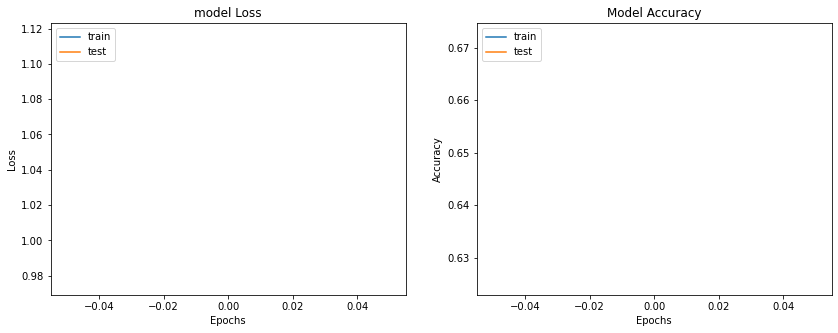

In [25]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(mod.history['accuracy'])
plt.plot(mod.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(mod.history['loss'])
plt.plot(mod.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
train_loss, train_accu = our_model.evaluate(train_set)
test_loss, test_accu = our_model.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

294/449 [==================>...........] - ETA: 15s - loss: 0.8362 - accuracy: 0.7355

In [ ]:
#ON TRAINING SET
y_pred = our_model.predict(train_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(train_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(train_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

In [ ]:
#ON TESTING SET
y_pred = our_model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)